In [387]:
from useful.getAssets import CC_DATABASE_INTERFACE
cryptocurrency_db = CC_DATABASE_INTERFACE()

In [388]:
import pandas as pd
ASSETS = ["MC","RACE","TTE","SHOP","NVDA","NKE"] # asset's list used in the program
PERIOD = ("2023-01-01","2023-11-01")
assetsData =[]
assetsPrices = pd.DataFrame()
for asset in ASSETS:
    assetData = cryptocurrency_db.getAssetData(asset,*PERIOD)
    assetDf = pd.DataFrame(assetData)
    assetDf = assetDf.set_index("date")
    assetDf = assetDf.set_index(pd.DatetimeIndex(assetDf.index))

    assetsPrices[asset] = assetDf["close"]
    assetsData.append(assetDf)
# assetsData[0].head()
# assetsPrices.head()

In [389]:
import random
def generateWeights(n):
    nombres = [0]
    for _ in range(n-1):
        nombres.append(random.uniform(0, 1-sum(nombres)))
    nombres.append(1-sum(nombres))
    return nombres[1:]

In [390]:
import numpy as np

weights = generateWeights(len(ASSETS))

dictWeights = {asset:weight for asset,weight in zip(ASSETS,weights)}

assets_returns = assetsPrices.pct_change().dropna()

# daily
expected_returns = assets_returns.mean()
returns_cov = assets_returns.cov()
variance = np.transpose(weights)@returns_cov@weights
risk = np.sqrt(variance)

pf_expected_return = weights@expected_returns
pf_variance = np.transpose(weights)@returns_cov@weights
pf_risk = np.sqrt(pf_variance)
pf_sharpe = pf_expected_return/pf_risk

# YEARLY
# returns cumulative annualisés en mul par la puissance 252/nb de rows
ytd_exp_returns = (assets_returns+1).prod() ** (252/assets_returns.count()) -1
ytd_returns_cov = returns_cov*252
ytd_variance = np.transpose(weights)@ytd_returns_cov@weights
ytd_risk = np.sqrt(ytd_variance)

ytd_pf_expected_return = weights@ytd_exp_returns
ytd_pf_var= np.transpose(weights)@ytd_returns_cov@weights
ytd_pf_risk = np.sqrt(ytd_pf_var)
ytd_pf_sr = (ytd_pf_expected_return)/ytd_pf_risk

print("Portfolio's performance :")
print("")
print("Expected returns : {}% (Daily)\t{}% (Yearly)".format(pf_expected_return*100,ytd_pf_expected_return*100))
print("Volatility : {}% Daily\t{}% Yearly".format(pf_risk*100,ytd_pf_risk*100))
print("Sharpe : {} (Daily)\t{} (Yearly)".format(pf_sharpe,ytd_pf_sr))
# base_portfolio = {"risk":pf_risk,"return":pf_expected_return}



Portfolio's performance :

Expected returns : 0.15316062692208418% (Daily)	44.66219882287514% (Yearly)
Volatility : 1.1580453330966218% Daily	18.383399749875707% Yearly
Sharpe : 0.13225788537356437 (Daily)	2.429485265541109 (Yearly)


In [398]:
import pypfopt

mu = pypfopt.expected_returns.mean_historical_return(assetsPrices)
S = pypfopt.risk_models.sample_cov(assetsPrices)
# en annualisé
ef0 = pypfopt.efficient_frontier.EfficientFrontier(mu,S)
ef0.set_weights(dictWeights)

ef0.portfolio_performance(verbose=True,risk_free_rate=0)
print(ef0.max_sharpe(risk_free_rate=0))
ef0.portfolio_performance(verbose=True,risk_free_rate=0)

print("")
# en daily
ef = pypfopt.efficient_frontier.EfficientFrontier(assets_returns.mean(),assets_returns.cov())
ef.set_weights(dictWeights)
ef.portfolio_performance(verbose=True)

Expected annual return: 44.7%
Annual volatility: 18.4%
Sharpe Ratio: 2.43
OrderedDict([('MC', 0.0), ('RACE', 0.2074187097257336), ('TTE', 0.0514560002161995), ('SHOP', 0.0), ('NVDA', 0.7411252900580669), ('NKE', 0.0)])
Expected annual return: 211.1%
Annual volatility: 40.1%
Sharpe Ratio: 5.26

Expected annual return: 0.2%
Annual volatility: 1.2%
Sharpe Ratio: -1.59


(0.0015316062692208418, 0.011580453330966219, -1.5947902213287743)

In [392]:
def portfolio_perfs(w,assets_returns,freq=252):
    """
    Args:
        assets_returns (df): daily returns
    """
    # on annualise
    expected_returns = (assets_returns+1).prod() ** (freq/assets_returns.count()) -1
    returns_cov_matrix = assets_returns.cov()*freq
    
    pf_variance = np.transpose(w)@returns_cov_matrix@w
    pf_risk = np.sqrt(pf_variance)
    
    pf_expected_return = w @ expected_returns
    pf_sharpe = pf_expected_return/pf_risk
    
    
    return {"w":w,"exp_returns":pf_expected_return,"risk":pf_risk,"sharpe":pf_sharpe}

portfolio_perfs(weights,assets_returns)

{'w': [0.11541906587697215,
  0.7937981125747623,
  0.07706644653917047,
  0.0056163335197274965,
  0.0035359305222010685,
  0.004564110967166579],
 'exp_returns': 0.44662198822875143,
 'risk': 0.18383399749875706,
 'sharpe': 2.429485265541109}

In [393]:
# générer pleins de portefeuilles avec Monte Carlo

generated_weights = []
generated_portfolios = []

nbIteration = 5000
for iteration in range(nbIteration):
    randomWeights = generateWeights(len(ASSETS))
    generated_weights.append(randomWeights)
    
    performances = portfolio_perfs(randomWeights,assets_returns)
    generated_portfolios.append(performances)

In [405]:
best_pf = max(generated_portfolios,key = lambda x:x["sharpe"])
# best_pf
cw = ef0.clean_weights().values()
alt_best_pf = portfolio_perfs(list(cw),assets_returns)
# alt_best_pf


Text(0.5, 1.0, 'generation of the effiency frontier - 5000 iterations')

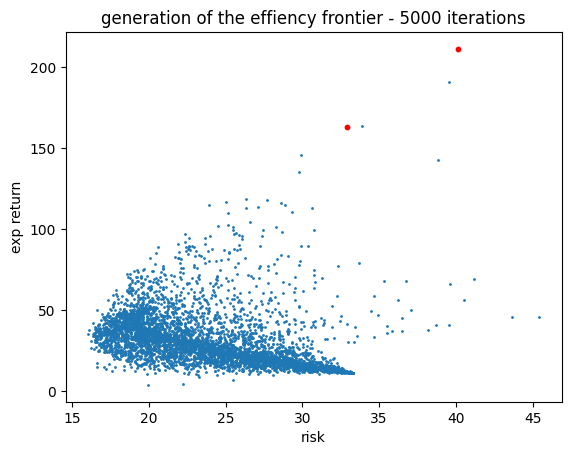

In [406]:
import matplotlib.pyplot as plt
df = pd.DataFrame(generated_portfolios)
plt.scatter(df["risk"]*100,df["exp_returns"]*100,s=1)
# plt.scatter(base_portfolio["risk"],base_portfolio["return"],s=6)
plt.scatter(best_pf["risk"]*100,best_pf["exp_returns"]*100,s=10,c="red")
plt.scatter(alt_best_pf["risk"]*100,alt_best_pf["exp_returns"]*100,s=10,c="red")
plt.xlabel("risk")
plt.ylabel("exp return")
plt.title("generation of the effiency frontier - "+str(nbIteration)+" iterations")